In [1]:
%load_ext autoreload
%autoreload 2
from ayniy.utils import init_notebook
init_notebook()

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb

In [3]:
def extract_feat(sid):
    df = pd.read_csv(f'../dataset/train/{sid}.csv')

    df['diff_scr_x'] = (df['scr_x'] - df['bal_x']).abs()
    df['diff_scr_y'] = (df['scr_y'] - df['bal_y']).abs()
    df['diff_usr_x'] = (df['usr_x'] - df['bal_x']).abs()
    df['diff_usr_y'] = (df['usr_y'] - df['bal_y']).abs()
    df['diff_uDF_x'] = (df['uDF_x'] - df['bal_x']).abs()
    df['diff_uDF_y'] = (df['uDF_y'] - df['bal_y']).abs()

    return (df['diff_scr_x'].min(), df['diff_scr_y'].min(), df['diff_usr_x'].min(), df['diff_usr_y'].min(), df['diff_uDF_x'].min(), df['diff_uDF_y'].min())

In [4]:
X_train = []

for i in range(1528):
    X_train.append(extract_feat(str(i).zfill(4)))

In [5]:
X_test = []

for i in range(382):
    X_test.append(extract_feat(str(i).zfill(4)))

In [6]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
cols = ['min_diff_scr_x', 'min_diff_scr_y', 'min_diff_usr_x', 'min_diff_usr_y', 'min_diff_uDF_x', 'min_diff_uDF_y']
X_train.columns = cols
X_test.columns = cols

In [7]:
X_train.head()

,min_diff_scr_x,min_diff_scr_y,min_diff_usr_x,min_diff_usr_y,min_diff_uDF_x,min_diff_uDF_y
0,1.13,0.05,0.05,0.00,1.79,0.17
1,0.02,0.00,0.03,0.00,0.02,0.05
2,0.07,4.66,0.06,0.01,0.00,0.03
3,0.01,0.20,0.00,0.00,0.03,0.00
4,1.82,0.08,2.12,0.23,2.59,0.03


In [8]:
y_train = pd.Series([1 if i < 400 else 0 for i in range(1528)])

In [16]:
from sklearn.model_selection import StratifiedKFold


y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 16,
    'max_depth': 3,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.7,
    'min_data_in_leaf': 10,
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "verbosity": -1,
    "random_state": 42
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    model = lgb.train(params, lgb_train,
                                   valid_sets=[lgb_train, lgb_eval],
                                   verbose_eval=10,
                                   num_boost_round=1000,
                                   early_stopping_rounds=10)

    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.740594	valid_1's auc: 0.649253
[20]	training's auc: 0.760331	valid_1's auc: 0.64729
Early stopping, best iteration is:
[10]	training's auc: 0.740594	valid_1's auc: 0.649253
Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.746222	valid_1's auc: 0.664546
[20]	training's auc: 0.76748	valid_1's auc: 0.671073
[30]	training's auc: 0.783679	valid_1's auc: 0.663413
Early stopping, best iteration is:
[21]	training's auc: 0.768814	valid_1's auc: 0.671958
Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.742725	valid_1's auc: 0.597373
[20]	training's auc: 0.763843	valid_1's auc: 0.60531
Early stopping, best iteration is:
[11]	training's auc: 0.745583	valid_1's auc: 0.609983
Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.735619	valid_1's auc: 0.703667
Early stopping, best iteration is:
[7]	training's auc: 0

In [18]:
pd.DataFrame(oof_train).to_csv('oof_train_skfold.csv', index=False)
print(oof_train[:10])

scores = [
    m.best_score['valid_1']['auc'] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

[0.24504988 0.28433517 0.24818302 0.27049217 0.22356153 0.30119325
 0.40181601 0.40181601 0.20916367 0.28331265]
===CV scores===
[0.6492533185840708, 0.6719579646017699, 0.609983407079646, 0.7088055555555556, 0.6835]
0.6647000491642084


In [24]:
from sklearn.metrics import accuracy_score


y_pred_oof = (oof_train > 0.5).astype(int)
accuracy_score(y_train, y_pred_oof)

0.7369109947643979

In [25]:
y_sub = sum(y_preds) / len(y_preds)
y_sub = (y_sub > 0.5).astype(int)
y_sub[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
y_sub = sum(y_preds) / len(y_preds)

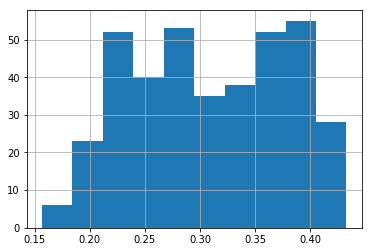

In [31]:
pd.Series(y_sub).hist()

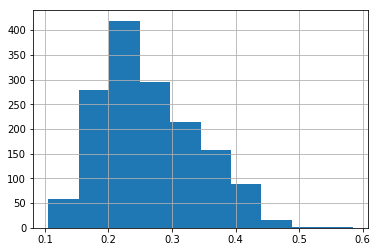

In [32]:
pd.Series(oof_train).hist()